In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import glob
import seaborn as sns
import numpy as np

## Read from `~/metrics/epoch_metrics/` directory

In [2]:
files = glob.glob("../../metrics/epoch_metrics/*parquet")

dataframes = []

for file in files:
    df = pd.read_parquet(file)
    
    dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True)

In [3]:
df["per_layer"] = df['total_rounds'].apply(lambda x: not isinstance(x, int))

In [4]:
import ast

def per_layer_columns(row):
    if row['per_layer']:
        
        tot_rounds = row['total_rounds']
        
        if isinstance(tot_rounds, str):
            return ast.literal_eval(row['total_rounds'])
        
        elif isinstance(row['total_rounds'], np.ndarray):
            return list(row['total_rounds'])
            
        else:
            print(type(row['total_rounds']))
            raise Exception("WTF")
    
    return row['total_rounds']

In [5]:
df['total_rounds'] = df.apply(per_layer_columns, axis=1)

In [6]:
#df = pd.read_parquet("../../metrics/epoch_metrics/")

## For Synchronous - "Centralized" investigation

In [7]:
df_synchronous = df[(df['fda_name'] == 'synchronous') & (df['aggr_scheme'] == 'avg')].copy()

In [8]:
df_synchronous['centralized_batch_size'] = df_synchronous['num_clients'] * df_synchronous['batch_size']

In [9]:
df_synchronous = df_synchronous.sort_values(by=['centralized_batch_size'], ascending=True)

# Hyper-Parameters

`bias` `NaN` -> no bias

`bias` $ \in (0, 1)$ -> `bias`% of each client's dataset is biased (from sorted sequence of MNIST) - rest is good

`bias` $= -1$ -> MNIST label 0 is sorted, placed at the start, and clients get assigned sequentially from this dataset. Only one label is biased to however many clients can get it assigned to them.

`bias` $= -2$ -> MNIST label 8 is sorted, placed at the start, and clients get assigned sequentially from this dataset. Only one label is biased to however many clients can get it assigned to them.

In [10]:
one_label_bias = {
    -1: 0,
    -2: 8
}

In [11]:
aggr = {
    'avg': '',
    'wavg_drifts': ' wavg'
}

In [12]:
per_layer_dict = {
    False: '',
    True: ' per-layer'
}

# Helpful new Dataframe metrics

### Add Helpful model metrics

In [13]:
df['model_bytes'] = df['nn_num_weights'] * 4

### Add Helpful FDA method metrics

In [14]:
def fda_local_state_bytes(row):
    if row['fda_name'] == "naive":
        return 4
    if row['fda_name'] == "linear":
        return 8
    if row['fda_name'] == "sketch":
        return row['sketch_width'] * row['sketch_depth'] * 4 + 4
    if row['fda_name'] == "synchronous":
        return 0
    if row['fda_name'] == 'gm':
        return 0.125  # one bit

In [15]:
df['local_state_bytes'] = df.apply(fda_local_state_bytes, axis=1)

### Add Total Steps

total steps (a single fda step might have many normal SGD steps, batch steps)

In [16]:
df['total_steps'] = df['total_fda_steps'] * df['num_steps_until_rtc_check']

### Add communication metrics

In [17]:
from fdavg.models.advanced_cnn import get_compiled_and_built_advanced_cnn
from fdavg.models.lenet5 import get_compiled_and_built_lenet

adv = get_compiled_and_built_advanced_cnn((None, 28, 28), (28, 28, 1), 10)

lenet = get_compiled_and_built_lenet((None, 28, 28), (28, 28, 1), 10)

adv_layer_count = [len(v) for v in adv.per_layer_trainable_vars_as_vector()]
lenet_layer_count = [len(v) for v in lenet.per_layer_trainable_vars_as_vector()]

2023-12-15 08:47:45.129710: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 08:47:45.410132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 08:47:45.410243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 08:47:45.448929: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 08:47:45.548574: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 08:47:45.550677: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [18]:
adv_layer_count

[640, 36928, 73856, 147584, 295168, 590080, 1180160, 262656, 5130]

In [19]:
lenet_layer_count

[156, 2416, 48120, 10164, 850]

The communication bytes exchanged for model synchronization. Remember that the Clients send their models to the Server and the Server sends the global model back. This happens at the end of every round.

In [20]:
# TODO: Densenet

def model_bytes_exchanged(row):
    if row['per_layer']:
        if row['nn_name'] == 'AdvancedCNN':
            return sum((layer_num_weights * 4) * layer_rounds * row['num_clients'] * 2 for layer_num_weights, layer_rounds in zip(adv_layer_count, row['total_rounds']))
        if row['nn_name'] == 'LeNet-5':
            print("lenet?")
            return sum((layer_num_weights * 4) * layer_rounds * row['num_clients'] * 2 for layer_num_weights, layer_rounds in zip(lenet_layer_count, row['total_rounds']))
    
    return row['total_rounds'] * row['model_bytes'] * row['num_clients'] * 2

In [21]:
df['model_bytes_exchanged'] = df.apply(model_bytes_exchanged, axis=1)

The communication bytes exchanged for monitoring the variance. This happens at the end of every FDA step which consists of `num_steps_until_rtc_check` number of steps. 

In [22]:
def monitoring_bytes_exchanged(row):
    if row['per_layer']:
        if row['nn_name'] == 'AdvancedCNN':
            return row['local_state_bytes'] * row['total_fda_steps'] * row['num_clients'] * len(adv_layer_count)
        if row['nn_name'] == 'LeNet-5':
            return row['local_state_bytes'] * row['total_fda_steps'] * row['num_clients'] * len(lenet_layer_count)
    
    return row['local_state_bytes'] * row['total_fda_steps'] * row['num_clients']

In [23]:
df['monitoring_bytes_exchanged'] = df.apply(monitoring_bytes_exchanged, axis=1)

The total communication bytes exchanged in the whole Federated Learning lifecycle.

In [24]:
df['total_communication_bytes'] = df['model_bytes_exchanged'] + df['monitoring_bytes_exchanged']

In [25]:
df['total_communication_gb'] = df['total_communication_bytes'] / 10**9

# HyperParameter ranking

### LeNet-5 - MNIST
On `Nvidia A10`:
1. Batch Size = 32 -> 6.613 ms ± 0.128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2. *Batch Size* = 64 -> 7.509 ms ± 0.065 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3. *Batch Size* = 128 -> 8.02 ms ± 0.099 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4. *Batch Size* = 256 -> 9.258 ms ± 0.336 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

### AdvancedCNN - MNIST

On `Nvidia A10`:
1. *Batch Size* = 32 -> 8.853 ms ± 0.0917 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2. *Batch Size* = 64 -> 10.325 ms ± 0.215 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3. *Batch Size* = 128 -> 11.989 ms ± 0.134 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4. *Batch Size* = 256 -> 16.47 ms ± 0.294 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

### DenseNet121 - CIFAR10

On `Nvidia A10`:
1. *Batch Size* = 32 -> 8.853 ms ± 0.0917 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2. *Batch Size* = 64 -> 10.325 ms ± 0.215 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3. *Batch Size* = 128 -> 11.989 ms ± 0.134 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4. *Batch Size* = 256 -> 16.47 ms ± 0.294 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [26]:
step_ms = {
    ("AdvancedCNN", 32): 8.853,
    ("AdvancedCNN", 64): 10.325,
    ("AdvancedCNN", 128): 11.989,
    ("AdvancedCNN", 256): 16.47,
    ("LeNet-5", 32): 6.613,
    ("LeNet-5", 64): 7.509,
    ("LeNet-5", 128): 8.02,
    ("LeNet-5", 256): 9.258,
    ("DenseNet121", 32): 87.328,
    ("DenseNet121", 64): 88.832,
    ("DenseNet121", 128): 94.208,
    ("DenseNet121", 256): 96.0
}

In [27]:
import numpy as np

def cpu_time_cost(row):
    """ Total cpu time cost in (sec).
    A single `step` means each client performed a single `step` 
    """
    return row['total_steps'] * step_ms[(row['nn_name'], row['batch_size'])] / 1000

def communication_time_cost(num_clients, total_communication_bytes, comm_model):
    """ Assuming channel is 1Gbps """

    total_communication_gbit = total_communication_bytes * 8e-9

    if comm_model == 'common_channel':
        
        return ((num_clients - 1) / num_clients) * total_communication_gbit    # sec

    if comm_model == 'hypercube':

        return (np.ceil(np.log(num_clients)) / num_clients) * total_communication_gbit   # sec

In [28]:
df['cpu_time_cost'] = df.apply(cpu_time_cost, axis=1)

In [29]:
df['hypercube_communication_time_cost'] = communication_time_cost(df['num_clients'], df['total_communication_bytes'], 'hypercube')

In [30]:
df['common_channel_communication_time_cost'] = communication_time_cost(df['num_clients'], df['total_communication_bytes'], 'common_channel')

In [31]:
df['hypercube_time_cost'] = df['cpu_time_cost'] + df['hypercube_communication_time_cost']

In [32]:
df['common_channel_time_cost'] = df['cpu_time_cost'] + df['common_channel_communication_time_cost']

In [33]:
df['hypercube_comm_cpu_time_ratio'] = df['hypercube_communication_time_cost'] / df['cpu_time_cost']

In [34]:
df['common_channel_comm_cpu_time_ratio'] = df['common_channel_communication_time_cost'] / df['cpu_time_cost']

# Plots about cost

In [35]:
# Define styles for each fda_name
fda_styles = {
    'naive': 'o-r',
    'linear': 's-g',
    'sketch': '^-b',
    'synchronous': 'x-c'
}
fda_names = ['gm', 'naive', 'linear', 'sketch', 'synchronous']

In [36]:
import matplotlib

num_clients_values = sorted(df['num_clients'].unique())
cmap = matplotlib.colormaps['tab20b']
colors_dict = {
    num_clients: color 
    for num_clients, color in zip(num_clients_values, cmap(np.linspace(0, 1, len(num_clients_values))))
}

## KDE Helper

In [37]:
"""
sns_params = {
    'bw_method': 'scott',
    'bw_adjust': 0.7,
    'fill': True,
    'alpha': 0.2
}
"""
sns_params = {
    'bw_method': 'scott',
    'bw_adjust': 0.7,
    'fill': False,
    'alpha': 1
}

sns_params_biases = {
    'bw_method': 'scott',
    'bw_adjust': 0.7,
    'fill': False,
    'alpha': 0.8
}

base_colors = {
    'gm': 'blue',
    'naive': 'orange',
    'linear': 'green',
    'sketch': 'red',
    'synchronous': 'purple',
    'sketch wavg': 'black'
}

base_colors_per_layer = {
    'gm': 'blue',
    'naive': 'orange',
    'linear': 'green',
    'sketch': 'red',
    'synchronous': 'purple',
    'naive per-layer': 'black'
}

sync_colors = {
    32: 'rebeccapurple',
    64: 'darkorchid',
    128: 'mediumorchid',
    256: 'plum'
}

In [38]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 14

## Total time cost with accuracy

### KDE

In [39]:
def kde_time_cost(df, filename, x_log=True):
    
    if x_log:
        log_scale = (True, False)
    else:
        log_scale = False
        
    plt.rcParams['font.size'] = 20
    plt.rcParams['legend.fontsize'] = 12
    
    pdf = PdfPages(filename)
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    per_layers = [False, True]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        if len(df_bias['fda_name'].unique()) < 2:
            continue
    
        fig, axs = plt.subplots(1, 2, figsize=(20, 8))
        
        for per_layer in per_layers:
                    
            per_layer_df = df_bias[df_bias['per_layer'] == per_layer]
        
            for fda_name in fda_names:
                
                name = f"{fda_name}{per_layer_dict[per_layer]}"
                
                fda_df = per_layer_df[per_layer_df['fda_name'] == fda_name]
                
                if fda_df.empty:
                    continue

                common_channel_df = fda_df['common_channel_time_cost']
                sns.kdeplot(common_channel_df, label=name, ax=axs[0], color=base_colors_per_layer[name], log_scale=log_scale, **sns_params)

                hypercube_df = fda_df['hypercube_time_cost']
                sns.kdeplot(hypercube_df, label=name, ax=axs[1], color=base_colors_per_layer[name], log_scale=log_scale, **sns_params)


        if not x_log:
            axs[0].set_xlim(left=0)
        axs[0].set_xlabel('Time Cost (sec)')
        axs[0].set_ylabel('Density')
        axs[0].legend()
        axs[0].set_title("Common Channel Communication Model")
        axs[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        axs[0].legend()

        if not x_log:
            axs[1].set_xlim(left=0)

        axs[1].set_xlabel('Time Cost (sec)')
        axs[1].set_ylabel('Density')
        axs[1].legend()
        axs[1].set_title("Hypercube Communication Model")
        axs[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        axs[1].legend()
        
        fda_df = df_bias[df_bias['fda_name'] != 'synchronous']
        sync_df = df_bias[df_bias['fda_name'] == 'synchronous']
        info = f"gm, naive, linear, sketch - bs : {fda_df['batch_size'].unique()}  ,  synchronous - bs: {sync_df['batch_size'].unique()}\n"
        fig.suptitle(info+bias_title)
        
        plt.tight_layout()

        pdf.savefig(fig)

        plt.close(fig)
    
        
    pdf.close()
    
    plt.rcParams['font.size'] = 14
    plt.rcParams['legend.fontsize'] = 12

## Total Communication cost (in gb) with accuracy (scatter)

### KDE

In [40]:
def kde_communication_cost(df, filename, x_log=True):

    if x_log:
        log_scale = (True, False)
    else:
        log_scale = False
        
    pdf = PdfPages(filename)
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    per_layers = [False, True]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        if len(df_bias['fda_name'].unique()) < 2:
            continue
    
        plt.figure(figsize=(10, 6))
        avg_info = []
        
        for per_layer in per_layers:
                    
            per_layer_df = df_bias[df_bias['per_layer'] == per_layer]
        
            for fda_name in fda_names:
                
                name = f"{fda_name}{per_layer_dict[per_layer]}"
                
                fda_df = per_layer_df[per_layer_df['fda_name'] == fda_name]
                
                if fda_df.empty:
                    continue

                fda_data_df = fda_df['total_communication_gb']

                avg_info.append(f'{name}: {fda_data_df.mean():.2f} GB')

                # Plotting only the KDE using kdeplot
                sns.kdeplot(fda_data_df, label=name, log_scale=log_scale, color=base_colors_per_layer[name], **sns_params)

        text = "Average Communication:\n" + '\n'.join(avg_info)
        # Add the text annotation inside the plot
        plt.text(0.02, 0.97, text, transform=plt.gca().transAxes, fontsize=9, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.4))

        if not x_log:
            plt.xlim(left=0)

        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        plt.xlabel('Communication (GB)')
        plt.ylabel('Density')
        #plt.legend()  # We'll be moving this
        plt.gca().legend(loc='best', bbox_to_anchor=(0, 0.05, 1, 0.67))
        
        fda_df = df_bias[df_bias['fda_name'] != 'synchronous']
        sync_df = df_bias[df_bias['fda_name'] == 'synchronous']
        info = f"gm, naive, linear, sketch - bs : {fda_df['batch_size'].unique()}  ,  synchronous - bs: {sync_df['batch_size'].unique()}\n"
        plt.suptitle(info+bias_title)

        plt.tight_layout()

        pdf.savefig(plt.gcf()) # Save the current figure

        # Close the current figure to prevent it from being displayed in the notebook
        plt.close()
    pdf.close()

## Total CPU time (in Seconds) with accuracy

### KDE

In [41]:
def kde_cpu_time_cost(df, filename, x_log=False):
    
    if x_log:
        log_scale = (True, False)
    else:
        log_scale = False
        
    pdf = PdfPages(filename)
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    per_layers = [False, True]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        if len(df_bias['fda_name'].unique()) < 2:
            continue
    
        plt.figure(figsize=(10, 6))
        
        for per_layer in per_layers:
                    
            per_layer_df = df_bias[df_bias['per_layer'] == per_layer]
        
            for fda_name in fda_names:
                
                name = f"{fda_name}{per_layer_dict[per_layer]}"
                
                fda_df = per_layer_df[per_layer_df['fda_name'] == fda_name]
                
                if fda_df.empty:
                    continue

                fda_data_df = fda_df['cpu_time_cost']

                # Plotting only the KDE using kdeplot
                sns.kdeplot(fda_data_df, label=name, log_scale=log_scale, color=base_colors_per_layer[name], **sns_params)

        if not x_log:
            plt.xlim(left=0)
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        plt.xlabel('CPU time cost (sec)')
        plt.ylabel('Density')
        plt.legend()
        
        fda_df = df_bias[df_bias['fda_name'] != 'synchronous']
        sync_df = df_bias[df_bias['fda_name'] == 'synchronous']
        info = f"gm, naive, linear, sketch - bs : {fda_df['batch_size'].unique()}  ,  synchronous - bs: {sync_df['batch_size'].unique()}\n"
        plt.suptitle(info+bias_title)
        
        plt.tight_layout()

        pdf.savefig(plt.gcf()) # Save the current figure
        
        # Close the current figure to prevent it from being displayed in the notebook
        plt.close()
    pdf.close()

## Total CPU cost / Comm Cost (time) - ratio 

In [42]:
def kde_comm_cpu_time_cost_ratio(df, filename, x_log=True):
    
    if x_log:
        log_scale = (True, False)
    else:
        log_scale = False
        
    plt.rcParams['font.size'] = 20
    plt.rcParams['legend.fontsize'] = 12
    
    pdf = PdfPages(filename)
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    per_layers = [False, True]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        if len(df_bias['fda_name'].unique()) < 2:
            continue
    
        fig, axs = plt.subplots(1, 2, figsize=(20, 8))
        
        for per_layer in per_layers:
                    
            per_layer_df = df_bias[df_bias['per_layer'] == per_layer]
        
            for fda_name in fda_names:
                
                name = f"{fda_name}{per_layer_dict[per_layer]}"
                
                fda_df = per_layer_df[per_layer_df['fda_name'] == fda_name]
                
                if fda_df.empty:
                    continue
            
                common_channel_ratio_df = fda_df['cpu_time_cost'] / fda_df['common_channel_communication_time_cost']
                sns.kdeplot(common_channel_ratio_df, label=name, ax=axs[0], color=base_colors_per_layer[name], log_scale=log_scale, **sns_params)

                hypercube_ratio_df = fda_df['cpu_time_cost'] / fda_df['hypercube_communication_time_cost']
                sns.kdeplot(hypercube_ratio_df, label=name, ax=axs[1], color=base_colors_per_layer[name], log_scale=log_scale, **sns_params)


        if not x_log:
            axs[0].set_xlim(left=0)
        axs[0].set_xlabel('CPU Time Cost / Comm. Time Cost')
        axs[0].set_ylabel('Density')
        axs[0].legend()
        axs[0].set_title("Common Channel Communication Model")
        axs[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        axs[0].legend()

        if not x_log:
            axs[1].set_xlim(left=0)

        axs[1].set_xlabel('CPU Time Cost / Comm. Time Cost')
        axs[1].set_ylabel('Density')
        axs[1].legend()
        axs[1].set_title("Hypercube Communication Model")
        axs[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        axs[1].legend()
        
        fda_df = df_bias[df_bias['fda_name'] != 'synchronous']
        sync_df = df_bias[df_bias['fda_name'] == 'synchronous']
        info = f"gm, naive, linear, sketch - bs : {fda_df['batch_size'].unique()}  ,  synchronous - bs: {sync_df['batch_size'].unique()}\n"
        fig.suptitle(info+bias_title)
        
        plt.tight_layout()

        pdf.savefig(fig)

        plt.close(fig)
    
        
    pdf.close()
    
    plt.rcParams['font.size'] = 14
    plt.rcParams['legend.fontsize'] = 12

## Biparte

In [534]:
sns_params_joint = {
    #'bw_method': 'scott',
    #'bw_adjust': 0.9,
    'fill': False,
    'alpha': 0.8
}


def kde_bivarte_cpu_comm(df, filename, x_log=True):

    if x_log:
        log_scale = (True, False)
    else:
        log_scale = False
        
    pdf = PdfPages(filename)
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        if df_bias.empty or len(df_bias['fda_name'].unique()) < 2:
            continue
    
        #plt.figure(figsize=(10, 6))
        
        if (len(df_bias[df_bias.fda_name == 'gm']) == 1 or
            len(df_bias[df_bias.fda_name == 'linear']) == 1 or
            len(df_bias[df_bias.fda_name == 'sketch']) == 1 or
            len(df_bias[df_bias.fda_name == 'naive']) == 1 or
            len(df_bias[df_bias.fda_name == 'synchronous']) == 1):
            continue

        # Plotting only the KDE using kdeplot
        g = sns.jointplot(df_bias, x='total_communication_gb', y='cpu_time_cost', hue='fda_name', log_scale=log_scale, kind="kde", height=9, palette=base_colors, **sns_params_joint)

        if not x_log:
            plt.xlim(left=0)
            
        plt.ylim(bottom=0)
            
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        
        g.set_axis_labels("Communication Cost (GB)", "CPU Time Cost (sec)")

        g.ax_joint.get_legend().set_title(None)

        
        fda_df = df_bias[df_bias['fda_name'] != 'synchronous']
        sync_df = df_bias[df_bias['fda_name'] == 'synchronous']
        
        general = f"All strategies : {bias_title}\n"
        fda_info = f"FDA :  b {sorted(list(fda_df['batch_size'].unique()))}  ,  Θ {sorted(list(fda_df['theta'].unique()))}\n"
        sync_info = f"synchronous : b {sorted(list(sync_df['batch_size'].unique()))}"
        
        plt.suptitle(general+fda_info+sync_info)

        plt.tight_layout()

        pdf.savefig(plt.gcf()) # Save the current figure

        # Close the current figure to prevent it from being displayed in the notebook
        plt.close()
    pdf.close()
    

def kde_bivarte_cpu_comm_investigation(df, filename, x_log=True):

    if x_log:
        log_scale = (True, False)
    else:
        log_scale = False
        
    pdf = PdfPages(filename)
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    num_clients_values = sorted(df['num_clients'].unique())

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        if df_bias.empty or len(df_bias['fda_name'].unique()) < 2:
            continue
            
        for num_clients in num_clients_values:
            
            df_clients = df_bias[df_bias.num_clients == num_clients]
            
            if (len(df_clients[df_clients.fda_name == 'gm']) == 1 or
                len(df_clients[df_clients.fda_name == 'linear']) == 1 or
                len(df_clients[df_clients.fda_name == 'sketch']) == 1 or
                len(df_clients[df_clients.fda_name == 'naive']) == 1 or
                len(df_clients[df_clients.fda_name == 'synchronous']) == 1):
                continue
                                                             
            #plt.figure(figsize=(10, 6))

            # Plotting only the KDE using kdeplot
            g = sns.jointplot(df_clients, x='total_communication_gb', y='cpu_time_cost', hue='fda_name', log_scale=log_scale, kind="kde", height=9, palette=base_colors, **sns_params_joint)

            if not x_log:
                plt.xlim(left=0)

            plt.ylim(bottom=0)

            plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

            g.set_axis_labels("Communication Cost (GB)", "CPU Time Cost (sec)")

            g.ax_joint.get_legend().set_title(None)


            fda_df = df_bias[df_bias['fda_name'] != 'synchronous']
            sync_df = df_bias[df_bias['fda_name'] == 'synchronous']
            
            general = f"All strategies : {bias_title}  ,  Num. Clients: {num_clients}\n"
            fda_info = f"FDA :  b {sorted(list(fda_df['batch_size'].unique()))}  ,  Θ {sorted(list(fda_df['theta'].unique()))}\n"
            sync_info = f"synchronous : b {sorted(list(sync_df['batch_size'].unique()))}"

            plt.suptitle(general+fda_info+sync_info)

            plt.tight_layout()

            pdf.savefig(plt.gcf()) # Save the current figure

            # Close the current figure to prevent it from being displayed in the notebook
            plt.close()
            
    pdf.close()
    

def kde_bivarte_cpu_comm_investigation_only_intersection(df, filename, x_log=True):

    if x_log:
        log_scale = (True, False)
    else:
        log_scale = False
        
    pdf = PdfPages(filename)
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    num_clients_values = sorted(df['num_clients'].unique())

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        if df_bias.empty or len(df_bias['fda_name'].unique()) < 2:
            continue
            
        for num_clients in num_clients_values:
            
            df_clients = df_bias[df_bias.num_clients == num_clients]
            
            intersection_theta = list(
                set(df_clients[df_clients.fda_name == 'gm']['theta'].unique()) &
                set(df_clients[df_clients.fda_name == 'linear']['theta'].unique()) &
                set(df_clients[df_clients.fda_name == 'naive']['theta'].unique()) &
                set(df_clients[df_clients.fda_name == 'sketch']['theta'].unique())
            )
            
            if len(intersection_theta) == 1:
                continue
            
            df_data = df_clients[(df_clients.fda_name == 'synchronous') | (df_clients.theta.isin(intersection_theta))]
    
            #plt.figure(figsize=(10, 6))

            # Plotting only the KDE using kdeplot
            g = sns.jointplot(df_data, x='total_communication_gb', y='cpu_time_cost', hue='fda_name', log_scale=log_scale, kind="kde", height=9, palette=base_colors, **sns_params_joint)

            if not x_log:
                plt.xlim(left=0)

            plt.ylim(bottom=0)

            plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

            g.set_axis_labels("Communication Cost (GB)", "CPU Time Cost (sec)")

            g.ax_joint.get_legend().set_title(None)


            fda_df = df_data[df_data['fda_name'] != 'synchronous']
            sync_df = df_data[df_data['fda_name'] == 'synchronous']
            
            general = f"All strategies : {bias_title}  ,  Num. Clients: {num_clients}\n"
            fda_info = f"FDA :  b {sorted(list(fda_df['batch_size'].unique()))}  ,  Θ {sorted(list(fda_df['theta'].unique()))}\n"
            sync_info = f"synchronous : b {sorted(list(sync_df['batch_size'].unique()))}"

            plt.suptitle(general+fda_info+sync_info)

            plt.tight_layout()

            pdf.savefig(plt.gcf()) # Save the current figure

            # Close the current figure to prevent it from being displayed in the notebook
            plt.close()
            
    pdf.close()

## Keep Hyper-parameters fixed and plot for filtered

In [535]:
def fda_methods_clients_time_cost(df, filename, without_synchronous=False):
    pdf = PdfPages(filename)
    
    batch_size_values = sorted(df['batch_size'].unique())
    theta_values = sorted(df['theta'].unique())[1:]
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    per_layers = [False, True]
    
    min_clients = min(df['num_clients'])
    max_clients = max(df['num_clients'])

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        for batch_size in batch_size_values:
            for theta in theta_values:

                filtered_df = df_bias[(df_bias['theta'] == theta) & (df_bias['batch_size'] == batch_size)] 

                if filtered_df.empty:
                    continue

                fig, axs = plt.subplots(1, 2, figsize=(20, 6))
                
                for per_layer in per_layers:
                    
                    per_layer_df = filtered_df[filtered_df['per_layer'] == per_layer]

                    for fda_name in fda_names:
                        
                        if fda_name == 'synchronous':
                            continue

                        name = f"{fda_name}{per_layer_dict[per_layer]}"

                        fda_data = per_layer_df[per_layer_df['fda_name'] == fda_name]

                        if fda_data.empty:
                            continue

                        axs[0].plot(fda_data['num_clients'], fda_data['common_channel_time_cost'], marker='o', color=base_colors_per_layer[name], label=name, markersize=3)
                        axs[1].plot(fda_data['num_clients'], fda_data['hypercube_time_cost'], marker='o', color=base_colors_per_layer[name], label=name, markersize=3)

                if not without_synchronous:
                    sync_df = df_bias[df_bias['fda_name'] == 'synchronous'] 
                    sync_batch_sizes = sorted(sync_df['batch_size'].unique())

                    for sync_batch_size in sync_batch_sizes:
                        synchronous_data = sync_df[sync_df['batch_size'] == sync_batch_size] 

                        if not synchronous_data.empty:
                            axs[0].plot(synchronous_data['num_clients'], synchronous_data['common_channel_time_cost'], marker='o', label=f'synchronous b{sync_batch_size}', color=sync_colors[sync_batch_size], markersize=3)
                            axs[1].plot(synchronous_data['num_clients'], synchronous_data['hypercube_time_cost'], marker='o', label=f'synchronous b{sync_batch_size}', color=sync_colors[sync_batch_size], markersize=3)

                x_ticks = list(range(min_clients, max_clients + 1, 5))

                if not without_synchronous: axs[0].set_yscale('log')
                axs[0].set_xticks(x_ticks)
                axs[0].set_xlabel('Number of clients')
                axs[0].legend()
                axs[0].set_title("Common Channel Communication Model")
                axs[0].set_ylabel('Time Cost')
                axs[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                if not without_synchronous: axs[1].set_yscale('log')
                axs[1].set_xticks(x_ticks)
                axs[1].set_xlabel('Number of clients')
                axs[1].legend()
                axs[1].set_title("Hypercube Communication Model")
                axs[1].set_ylabel('Time Cost')
                axs[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                title = f'Batch Size : {batch_size} , $\Theta$ : {theta} , {bias_title}'
                fig.suptitle(title)

                plt.tight_layout()

                pdf.savefig(fig)

                plt.close(fig)
    pdf.close()

In [536]:
def fda_methods_clients_comm_cost(df, filename, without_synchronous=False):
    pdf = PdfPages(filename)
    
    batch_size_values = sorted(df['batch_size'].unique())
    theta_values = sorted(df['theta'].unique())[1:]
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    min_clients = min(df['num_clients'])
    max_clients = max(df['num_clients'])
    
    per_layers = [False, True]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        for batch_size in batch_size_values:
            for theta in theta_values:

                filtered_df = df_bias[(df_bias['theta'] == theta) & (df_bias['batch_size'] == batch_size)] 

                if filtered_df.empty:
                    continue

                plt.figure(figsize=(10, 6))
                
                for per_layer in per_layers:
                    
                    per_layer_df = filtered_df[filtered_df['per_layer'] == per_layer]

                    for fda_name in fda_names:
                        
                        if fda_name == 'synchronous':
                            continue

                        name = f"{fda_name}{per_layer_dict[per_layer]}"

                        fda_data = per_layer_df[per_layer_df['fda_name'] == fda_name]

                        if fda_data.empty:
                            continue

                        plt.plot(fda_data['num_clients'], fda_data['total_communication_gb'], marker='o', color=base_colors_per_layer[name], label=name, markersize=3)

                
                if not without_synchronous:
                    sync_df = df_bias[df_bias['fda_name'] == 'synchronous'] 
                    sync_batch_sizes = sorted(sync_df['batch_size'].unique())

                    for sync_batch_size in sync_batch_sizes:
                        synchronous_data = sync_df[sync_df['batch_size'] == sync_batch_size] 

                        if not synchronous_data.empty:
                            plt.plot(synchronous_data['num_clients'], synchronous_data['total_communication_gb'], marker='o', label=f'synchronous b{sync_batch_size}', color=sync_colors[sync_batch_size], markersize=3)

                x_ticks = list(range(min_clients, max_clients + 1, 5))

                if not without_synchronous:
                    plt.yscale('log')
                plt.xticks(x_ticks)
                plt.xlabel('Number of clients')
                plt.legend()
                plt.ylabel('Communication (GB)')
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                title = f'Batch Size : {batch_size} , $\Theta$ : {theta} , {bias_title}'
                plt.suptitle(title)

                plt.tight_layout()

                pdf.savefig(plt.gcf()) # Save the current figure
        
                # Close the current figure to prevent it from being displayed in the notebook
                plt.close()
    pdf.close()

In [537]:
def fda_methods_clients_cpu_cost(df, filename):
    pdf = PdfPages(filename)
    
    batch_size_values = sorted(df['batch_size'].unique())
    theta_values = sorted(df['theta'].unique())[1:]
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    per_layers = [False, True]
    
    min_clients = min(df['num_clients'])
    max_clients = max(df['num_clients'])

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        for batch_size in batch_size_values:
            for theta in theta_values:

                filtered_df = df_bias[(df_bias['theta'] == theta) & (df_bias['batch_size'] == batch_size)] 
                    
                if filtered_df.empty:
                    continue

                plt.figure(figsize=(10, 6))
                
                for per_layer in per_layers:
                    
                    per_layer_df = filtered_df[filtered_df['per_layer'] == per_layer]

                    for fda_name in fda_names:
                        
                        if fda_name == 'synchronous':
                            continue

                        name = f"{fda_name}{per_layer_dict[per_layer]}"

                        fda_data = per_layer_df[per_layer_df['fda_name'] == fda_name]

                        if fda_data.empty:
                            continue

                        plt.plot(fda_data['num_clients'], fda_data['cpu_time_cost'], marker='o', color=base_colors_per_layer[name], label=name, markersize=3)

                sync_df = df_bias[df_bias['fda_name'] == 'synchronous'] 
                sync_batch_sizes = sorted(sync_df['batch_size'].unique())

                for sync_batch_size in sync_batch_sizes:
                    synchronous_data = sync_df[sync_df['batch_size'] == sync_batch_size] 

                    if not synchronous_data.empty:
                        plt.plot(synchronous_data['num_clients'], synchronous_data['cpu_time_cost'], marker='o', label=f'synchronous b{sync_batch_size}', color=sync_colors[sync_batch_size], markersize=3)

                x_ticks = list(range(min_clients, max_clients + 1, 5))

                #plt.yscale('log')
                plt.xticks(x_ticks)
                plt.xlabel('Number of clients')
                plt.legend()
                plt.ylabel('CPU Time Cost (sec)')
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                title = f'Batch Size : {batch_size} , $\Theta$ : {theta} , {bias_title}'
                plt.suptitle(title)

                plt.tight_layout()

                pdf.savefig(plt.gcf()) # Save the current figure
        
                # Close the current figure to prevent it from being displayed in the notebook
                plt.close()
    pdf.close()

In [538]:
def fda_methods_theta_time_cost(df, filename):
    pdf = PdfPages(filename)
    
    batch_size_values = sorted(df['batch_size'].unique())
    num_clients_values = sorted(df['num_clients'].unique())
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    per_layers = [False, True]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]

        for batch_size in batch_size_values:
            for num_clients in num_clients_values:

                filtered_df = df_bias[(df_bias['batch_size'] == batch_size) & (df_bias['num_clients'] == num_clients)] 

                if filtered_df[filtered_df['fda_name'] != 'synchronous'].empty:
                    continue

                fig, axs = plt.subplots(1, 2, figsize=(20, 6))

                for per_layer in per_layers:
                    
                    per_layer_df = filtered_df[filtered_df['per_layer'] == per_layer]

                    for fda_name in fda_names:
                        
                        if fda_name == 'synchronous':
                            continue

                        name = f"{fda_name}{per_layer_dict[per_layer]}"

                        fda_data = per_layer_df[per_layer_df['fda_name'] == fda_name]

                        if fda_data.empty:
                            continue

                        axs[0].plot(fda_data['theta'], fda_data['common_channel_time_cost'], marker='o', label=name, color=base_colors_per_layer[name], markersize=3)
                        axs[1].plot(fda_data['theta'], fda_data['hypercube_time_cost'], marker='o', label=name, color=base_colors_per_layer[name], markersize=3)

                synchronous_data = df_bias[(df_bias['batch_size'] == batch_size) & (df_bias['fda_name'] == 'synchronous') & (df_bias['num_clients'] == num_clients)] 

                if not synchronous_data.empty:
                    axs[0].axhline(y=synchronous_data['common_channel_time_cost'].iloc[0], label='synchronous', marker='o', color=base_colors['synchronous'], markersize=3)
                    axs[1].axhline(y=synchronous_data['hypercube_time_cost'].iloc[0], label='synchronous', marker='o', color=base_colors['synchronous'], markersize=3)

                if not axs[0].has_data():
                    plt.close(fig)
                    continue

                axs[0].set_yscale('log')
                axs[0].set_xlabel('Theta')
                axs[0].legend()
                axs[0].set_title("Common Channel Communication Model")
                axs[0].set_ylabel('Time Cost')
                axs[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                axs[1].set_yscale('log')
                axs[1].set_xlabel('Theta')
                axs[1].legend()
                axs[1].set_title("Hypercube Communication Model")
                axs[1].set_ylabel('Time Cost')
                axs[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                title = f'Batch Size : {batch_size} , Num Clients : {num_clients} , {bias_title}'
                fig.suptitle(title)

                plt.tight_layout()

                pdf.savefig(fig)

                plt.close(fig)
    pdf.close()

In [539]:
def fda_methods_theta_comm_cost(df, filename):
    pdf = PdfPages(filename)
    
    batch_size_values = sorted(df['batch_size'].unique())
    num_clients_values = sorted(df['num_clients'].unique())
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    per_layers = [False, True]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]

        for batch_size in batch_size_values:
            for num_clients in num_clients_values:

                filtered_df = df_bias[(df_bias['batch_size'] == batch_size) & (df_bias['num_clients'] == num_clients)] 

                if filtered_df[filtered_df['fda_name'] != 'synchronous'].empty:
                    continue

                plt.figure(figsize=(10, 6))

                for per_layer in per_layers:
                    
                    per_layer_df = filtered_df[filtered_df['per_layer'] == per_layer]

                    for fda_name in fda_names:
                        
                        if fda_name == 'synchronous':
                            continue

                        name = f"{fda_name}{per_layer_dict[per_layer]}"

                        fda_data = per_layer_df[per_layer_df['fda_name'] == fda_name]

                        if fda_data.empty:
                            continue

                        plt.plot(fda_data['theta'], fda_data['total_communication_gb'], marker='o', label=name, color=base_colors_per_layer[name], markersize=3)

                synchronous_data = df_bias[(df_bias['batch_size'] == batch_size) & (df_bias['fda_name'] == 'synchronous') & (df_bias['num_clients'] == num_clients)] 

                if not synchronous_data.empty:
                    plt.axhline(y=synchronous_data['total_communication_gb'].iloc[0], label='synchronous', marker='o', color=base_colors['synchronous'], markersize=3)

                plt.yscale('log')
                plt.xlabel('Theta')
                plt.legend()
                plt.ylabel('Communication Cost (GB)')
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                title = f'Batch Size : {batch_size} , Num Clients : {num_clients} , {bias_title}'
                plt.suptitle(title)

                plt.tight_layout()

                pdf.savefig(plt.gcf())

                plt.close()
    pdf.close()

In [540]:
def fda_methods_theta_cpu_cost(df, filename):
    pdf = PdfPages(filename)
    
    batch_size_values = sorted(df['batch_size'].unique())
    num_clients_values = sorted(df['num_clients'].unique())
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    per_layers = [False, True]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]

        for batch_size in batch_size_values:
            for num_clients in num_clients_values:

                filtered_df = df_bias[(df_bias['batch_size'] == batch_size) & (df_bias['num_clients'] == num_clients)] 

                if filtered_df[filtered_df['fda_name'] != 'synchronous'].empty:
                    continue

                plt.figure(figsize=(10, 6))

                for per_layer in per_layers:
                    
                    per_layer_df = filtered_df[filtered_df['per_layer'] == per_layer]

                    for fda_name in fda_names:
                        
                        if fda_name == 'synchronous':
                            continue

                        name = f"{fda_name}{per_layer_dict[per_layer]}"

                        fda_data = per_layer_df[per_layer_df['fda_name'] == fda_name]

                        if fda_data.empty:
                            continue

                        plt.plot(fda_data['theta'], fda_data['cpu_time_cost'], marker='o', label=name, color=base_colors_per_layer[name], markersize=3)

                synchronous_data = df_bias[(df_bias['batch_size'] == batch_size) & (df_bias['fda_name'] == 'synchronous') & (df_bias['num_clients'] == num_clients)] 

                if not synchronous_data.empty:
                    plt.axhline(y=synchronous_data['cpu_time_cost'].iloc[0], label='synchronous', marker='o', color=base_colors['synchronous'], markersize=3)

                #plt.yscale('log')
                plt.xlabel('Theta')
                plt.legend()
                plt.ylabel('CPU Time Cost (sec)')
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                title = f'Batch Size : {batch_size} , Num Clients : {num_clients} , {bias_title}'
                plt.suptitle(title)

                plt.tight_layout()

                pdf.savefig(plt.gcf())

                plt.close()
    pdf.close()

# Per accuracy

In [541]:
def accuracies_plots(df, filename, accuracies):
    pdf = PdfPages(filename)

    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    per_layers = [False, True]

    for bias in biases:

        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'

        df_bias = df[mask]
        
        for bs in sorted(df_bias['batch_size'].unique()):

            bs_df = df_bias[df_bias['batch_size'] == bs]
                
            for theta in sorted(bs_df['theta'].unique())[1:]:

                theta_df = bs_df[bs_df['theta'] == theta]

                for client in sorted(theta_df['num_clients'].unique()):

                    client_df = theta_df[theta_df['num_clients'] == client]
                    
                    plt.figure(figsize=(10, 6))
                    
                    for per_layer in per_layers:
                    
                        per_layer_df = client_df[client_df['per_layer'] == per_layer]

                        for fda_name in fda_names:

                            if fda_name == 'synchronous':
                                continue

                            name = f"{fda_name}{per_layer_dict[per_layer]}"

                            fda_df = per_layer_df[per_layer_df['fda_name'] == fda_name]

                            if fda_df.empty:
                                continue

                            dataframes_for_acc = []
                            have = False

                            for acc in accuracies:

                                filtered_df = fda_df[(fda_df.accuracy > acc)]

                                if filtered_df.empty:
                                    continue

                                have = True

                                idx = filtered_df['epoch'].idxmin()
                                filtered_df = filtered_df.loc[idx]

                                dataframes_for_acc.append(filtered_df)

                            if not have:
                                continue

                            df_concat = pd.concat(dataframes_for_acc)

                            plt.plot(df_concat['accuracy'], df_concat['total_communication_gb'], marker='o', color=base_colors_per_layer[name], label=name, markersize=3)

                        synchronous_df = df_bias[(df_bias['num_clients'] == client) & (df_bias['fda_name'] == 'synchronous')]

                    for b in sorted(synchronous_df['batch_size'].unique()):

                        sync_df = synchronous_df[synchronous_df['batch_size'] == b]

                        if sync_df.empty:
                            continue

                        dataframes_for_acc = []

                        have = False

                        for acc in accuracies:

                            filtered_df = sync_df[(sync_df.accuracy > acc)]

                            if filtered_df.empty:
                                continue

                            have = True

                            idx = filtered_df['epoch'].idxmin()
                            filtered_df = filtered_df.loc[idx]

                            dataframes_for_acc.append(filtered_df)


                        if not have:
                            continue 

                        df_concat = pd.concat(dataframes_for_acc)

                        plt.plot(df_concat['accuracy'], df_concat['total_communication_gb'], color=sync_colors[b], marker='o', label=f'synchronous b{b}', markersize=3)

                    plt.yscale('log')
                    plt.xlabel('Accuracy')
                    plt.legend()
                    plt.ylabel('Communication Cost (GB)')
                    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                    title = f'$Theta$ : {theta} , Batch Size: {bs} , {bias_title} , Num Clients: {client}'
                    plt.title(title)

                    pdf.savefig(plt.gcf())

                    plt.close()
    pdf.close()

In [542]:
def centralized_synchronous_plots(df, acc_threshold, filename):
    pdf = PdfPages(filename)

    biases = sorted(df['bias'].unique(), reverse=True)[::-1]
    
    acc_df = df[(df.accuracy > acc_threshold)]
    
    # 2. Filter out same runs. We choose the instance which first hits the `acc_threshold`
    idx = acc_df.groupby(['centralized_batch_size', 'bias'], dropna=False)['epoch'].idxmin()
    filtered_acc_df = acc_df.loc[idx]

    for bias in biases:

        if pd.isna(bias):
            mask = filtered_acc_df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = filtered_acc_df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = filtered_acc_df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'

        df_bias = filtered_acc_df[mask]
        
        # ````````` here
        
        plt.figure(figsize=(10, 6))
        
        plt.plot(df_bias['centralized_batch_size'], df_bias['total_fda_steps'], marker='o', markersize=3)
        

        #plt.xscale('log')
        plt.ylabel('Steps')
        plt.xlabel('Batch Size')
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

        title = f'{bias_title}'
        plt.title(title)
        plt.suptitle("Synchronous Centralized")

        pdf.savefig(plt.gcf())

        plt.close()
        
    pdf.close()

# Help-Stat

In [543]:
def explore_top(df, acc_thresh, nn_name, fda_name):
    acceptable_acc_df = df[(df.accuracy > acc_thresh) & (df.nn_name == nn_name)]
    fda_df = acceptable_acc_df[acceptable_acc_df['fda_name'] == fda_name]
    
    idx = fda_df.groupby(['fda_name', 'num_clients', 'bias', 'batch_size', 'theta', 'aggr_scheme', 'per_layer'], dropna=False)['epoch'].idxmin()
    aggr_df = fda_df.loc[idx]
    
    print(len(aggr_df))
    
    aggr_df['monitoring_gb_exchanged'] = aggr_df['monitoring_bytes_exchanged'] / 10**9
    aggr_df['model_gb_exchanged'] = aggr_df['model_bytes_exchanged'] / 10**9
    
    #return filtered_acceptable_acc_df
    return aggr_df[['num_clients', 'batch_size', 'theta', 'bias', 'per_layer', 'total_rounds', 'total_fda_steps', 'epoch', 'monitoring_gb_exchanged', 'model_gb_exchanged', 'total_communication_gb', 'cpu_time_cost', 'hypercube_time_cost', 'common_channel_time_cost']].sort_values(by='common_channel_time_cost')

## Save all those time-cost plots

In [544]:
import os

def time_cost_plots(df, acc_threshold, nn_name, limit_x_axis=False, show_runs=False, params=False, kde_time_log=True, kde_comm_log=True, kde_cpu_log=False):
    # Filter out based on `acc_threshold`
    df_nn = df[(df.nn_name == nn_name)]
    
    acceptable_acc_df = df_nn[(df_nn.accuracy > acc_threshold)]
    
    str_thresh = str(acc_threshold).replace('.', '_')  # replace '.'
    
    if not os.path.exists(f"../../metrics/plots/{nn_name}/{str_thresh}"):
        os.makedirs(f"../../metrics/plots/{nn_name}/{str_thresh}")
        
    # 1. Same runs not included
    
    # 2. Filter out same runs. We choose the instance which first hits the `acc_threshold`
    idx = acceptable_acc_df.groupby(['fda_name', 'num_clients', 'batch_size', 'theta', 'bias', 'aggr_scheme', 'per_layer'], dropna=False)['epoch'].idxmin()
    filtered_acceptable_acc_df = acceptable_acc_df.loc[idx]
    
    #kde_time_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/time_cost.pdf", x_log=kde_time_log)
    
    #kde_communication_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/comm_cost.pdf", x_log=kde_comm_log)
    
    #kde_cpu_time_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/cpu_cost.pdf", x_log=kde_cpu_log)
    
    #kde_comm_cpu_time_cost_ratio(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/ratio.pdf", x_log=kde_comm_log)
    
    df_filt_simple = filtered_acceptable_acc_df[(~filtered_acceptable_acc_df.per_layer) & (filtered_acceptable_acc_df.aggr_scheme == 'avg') & (filtered_acceptable_acc_df.bias != 0.9)]  #  filter out weird tests
    
    kde_bivarte_cpu_comm(df_filt_simple, f"../../metrics/plots/{nn_name}/{str_thresh}/biparte.pdf")
    kde_bivarte_cpu_comm_investigation(df_filt_simple, f"../../metrics/plots/{nn_name}/{str_thresh}/biparte_per_clients.pdf")
    kde_bivarte_cpu_comm_investigation_only_intersection(df_filt_simple, f"../../metrics/plots/{nn_name}/{str_thresh}/biparte_per_clients_only_intersection_theta.pdf")
    
    # Parameters fixed, and plot
    if params:
        fda_methods_clients_time_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/clients_time_cost.pdf")
        fda_methods_clients_comm_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/clients_comm_cost.pdf")
        fda_methods_clients_cpu_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/clients_cpu_cost.pdf")
        
        fda_methods_clients_comm_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/clients_comm_cost_no_sync.pdf", without_synchronous=True)
        fda_methods_clients_time_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/clients_time_cost_no_sync.pdf", without_synchronous=True)
        
        fda_methods_theta_time_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/theta_time_cost.pdf")
        fda_methods_theta_comm_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/theta_comm_cost.pdf")
        fda_methods_theta_cpu_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/theta_cpu_cost.pdf")

In [505]:
df_32 = df[
    ((df['batch_size'] == 32) | (df['fda_name'] == 'synchronous')) & (df['aggr_scheme'] == 'avg')
]

In [506]:
df_theta = df[
    ((df['theta'] >= 15.) | (df['fda_name'] == 'synchronous')) & (df['aggr_scheme'] == 'avg')
]

In [507]:
df_lenet = df_32

In [508]:
df_adv = df_theta

## DenseNet121 - CIFAR10

In [222]:
df_dense = df_32[((df_32.theta == 250.0) | (df_32.theta == 0)) & (df_32['nn_name'] == 'DenseNet121')]

In [223]:
time_cost_plots(df_dense, 0.8, 'DenseNet121', params=True)

In [224]:
time_cost_plots(df_dense, 0.81, 'DenseNet121', params=True)

In [182]:
accuracies_plots(df_dense, f"../../metrics/plots/DenseNet121/accuracies.pdf", accuracies=[0.3, 0.4, 0.5, 0.6, 0.7, 0.73, 0.76, 0.8, 0.81])

In [187]:
centralized_synchronous_plots(df_synchronous[df_synchronous['nn_name'] == 'DenseNet121'], 0.8, f"../../metrics/plots/DenseNet121/0_8/centralized_synchronous.pdf")

In [188]:
centralized_synchronous_plots(df_synchronous[df_synchronous['nn_name'] == 'DenseNet121'], 0.81, f"../../metrics/plots/DenseNet121/0_81/centralized_synchronous.pdf")

## AdvancedCNN - MNIST

In [545]:
time_cost_plots(df_adv, 0.99, 'AdvancedCNN', params=False)
time_cost_plots(df_adv, 0.993, 'AdvancedCNN', params=False)
time_cost_plots(df_adv, 0.995, 'AdvancedCNN', params=False)

/home/miketheologitis/anaconda3/envs/data-analysis/lib/python3.11/site-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)
/home/miketheologitis/anaconda3/envs/data-analysis/lib/python3.11/site-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


In [ ]:
accuracies_plots(df_32[df_32['nn_name'] == 'AdvancedCNN'], f"../../metrics/plots/AdvancedCNN/accuracies.pdf", accuracies=[0.98, 0.985, 0.99, 0.991, 0.992, 0.993, 0.994, 0.995, 0.996])

In [ ]:
centralized_synchronous_plots(df_synchronous[df_synchronous['nn_name'] == 'AdvncedCNN'], 0.99, f"../../metrics/plots/AdvancedCNN/0_99/centralized_synchronous.pdf")

In [ ]:
centralized_synchronous_plots(df_synchronous[df_synchronous['nn_name'] == 'AdvncedCNN'], 0.993, f"../../metrics/plots/AdvancedCNN/0_993/centralized_synchronous.pdf")

In [ ]:
centralized_synchronous_plots(df_synchronous[df_synchronous['nn_name'] == 'AdvncedCNN'], 0.995, f"../../metrics/plots/AdvancedCNN/0_995/centralized_synchronous.pdf")

In [ ]:
#testing(df_theta, 0.99, 'AdvancedCNN')

## LeNet-5 - MNIST

In [ ]:
#explore_top(df, 0.98, 'LeNet-5', 'linear')

AttributeError: 'NoneType' object has no attribute 'set_title'

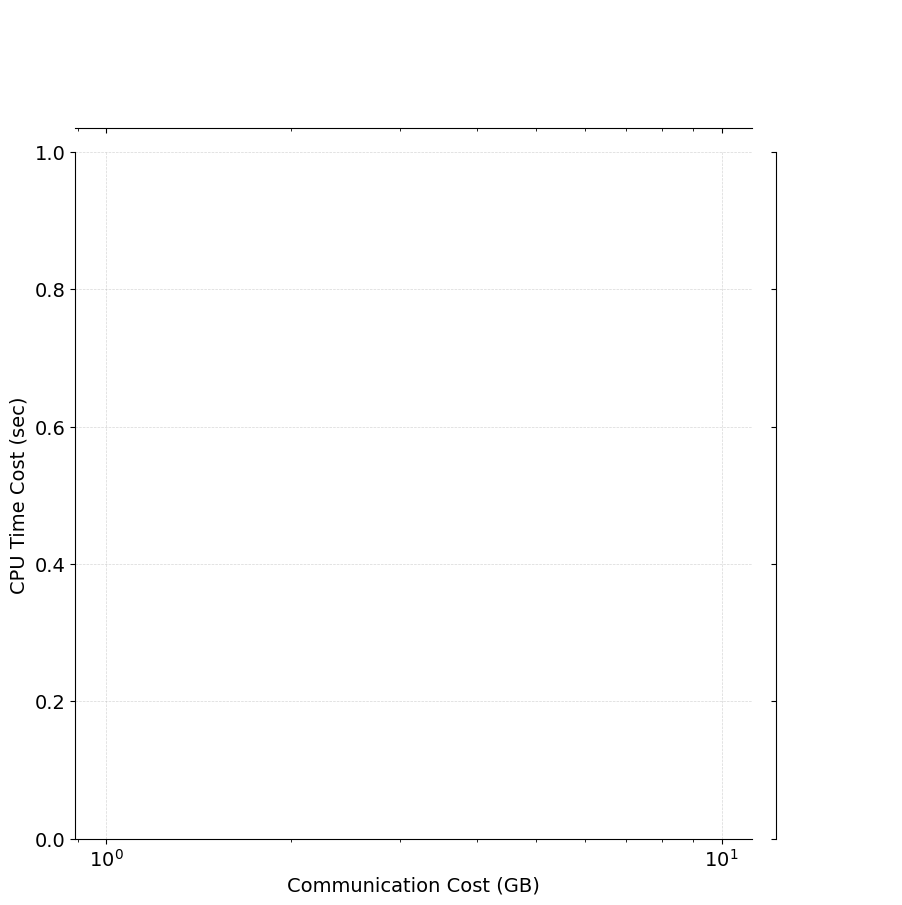

In [427]:
time_cost_plots(df_lenet, 0.98, 'LeNet-5', params=False)
time_cost_plots(df_lenet, 0.975, 'LeNet-5', params=False)
time_cost_plots(df_lenet, 0.985, 'LeNet-5', params=False)

In [ ]:
#accuracies_plots(df_lenet[df_lenet['nn_name'] == 'LeNet-5'], f"../../metrics/plots/LeNet-5/accuracies_clients.pdf", accuracies=[0.96, 0.965, 0.96, 0.965, 0.98, 0.982, 0.984, 0.985, 0.987, 0.989])

In [92]:
centralized_synchronous_plots(df_synchronous[df_synchronous['nn_name'] == 'LeNet-5'], 0.975, f"../../metrics/plots/LeNet-5/0_975/centralized_synchronous.pdf")

In [93]:
centralized_synchronous_plots(df_synchronous[df_synchronous['nn_name'] == 'LeNet-5'], 0.98, f"../../metrics/plots/LeNet-5/0_98/centralized_synchronous.pdf")

In [94]:
centralized_synchronous_plots(df_synchronous[df_synchronous['nn_name'] == 'LeNet-5'], 0.985, f"../../metrics/plots/LeNet-5/0_985/centralized_synchronous.pdf")